# Languages Dataset

Load languages dataset



In [191]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import hashlib
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
from pprint import pprint

pd.options.mode.chained_assignment = None
# Add the project root to the path to allow importing from `part2`
sys.path.insert(0, os.path.abspath('.'))
from part2.logprobs_cli import get_logprobs

sns.set_theme(style="whitegrid")

In [192]:
splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}

# Requires optional fsspec and huggingface hub dependency; install it with pip install fsspec
df = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["train"])

df.head(10)

,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão o acordo para fo..."
1,bg,размерът на хоризонталната мрежа може да бъде по реда на няколко километра ( km ) за на симулация до около 100 km за...
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不用认真的评论了，不用想还差多少字，直接发出就可以了，推荐给大家！！
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ของเก่า ที่ ไม่ 29 สำหรับ เฟอร์นิเจอร์ และ เงิน ไท ร้อง บริษัท ที...
4,ru,Он увеличил давление .
5,pl,"S Jak sobie życzysz: Widzisz, jak Hitler zabija Żydów?"
6,ur,اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید اورنمایاں طور پر سفید اورنمایاں طور پر .
7,sw,"Zabuni ya ushindani pia imekuwa rahisi kwa sifa ya kurudi kwenye mapendekezo yake ya grant , na dudovitz hivi karibu..."
8,tr,"Devasa 12 yüzyıl abbatiale saint-Pierre-Et-Saint-Paul , Aziz Peter ' ın 17 yüzyılda Roma ' da tamamlama kadar Hırist..."
9,ur,موجودہ اثاثوں میں سے ایک کا اضافہ ہو سکتا ہے ۔


In [193]:
# Naive approach, use default models and prompt
prompt_template = """
Given the text below, determine the single most appropriate ISO 639-1 language code based on what language the text is written in. 

Rules:
- Do not explain your answer.
- Do not output any punctuation marks.
- Do not output anything except the ISO 639-1 compliant code.

Text:
{text}

Language code:
"""

# prompt_template = """
# Given the text below, determine the single most appropriate ISO 639 language code as a formatted label LANG_{{ISO_CODE}}

# Rules:
# - Choose exactly one code from the list.
# - Do not explain your answer.
# - Do not output any punctuation marks.
# - Do not output anything except the language label, formatted like LANG_{{ISO_CODE}}

# Text:
# {text}

# Language code:
# """

sample = df.iloc[0]
txt = sample['text']

prompt = prompt_template.format(text=df.iloc[0]['text'])
result = get_logprobs(provider='ollama', model_id='llama3:8b', prompt=prompt, top_logprobs=3, temperature=0, invert_log=False)

print("Prompt:", prompt)
# Wrong classification
print("logprobs:")
pprint(dict(result.logprobs))
print("True Label:", sample['labels'])

Prompt: 
Given the text below, determine the single most appropriate ISO 639-1 language code based on what language the text is written in. 

Rules:
- Do not explain your answer.
- Do not output any punctuation marks.
- Do not output anything except the ISO 639-1 compliant code.

Text:
os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão o acordo para fornecer pessoal e financiamento para o centro.

Language code:

logprobs:
{'et': -0.188241109251976, 'lv': -5.697152137756348, 'pt': -1.8361293077468872}
True Label: pt


In [194]:
# We define two metrics, log margin and entropy, both for logprobs
from scipy.special import logsumexp
from scipy.stats import entropy


def log_margin(logprobs: dict) -> float:
    """
    The difference in logspace between the top choice and the second choice.
    """
    vals = list(logprobs.values())
    vals.sort(reverse=True)
    return vals[0] - vals[1]



def predictive_entropy(logprobs: dict) -> float:
    """
    Compute predictive entropy from log-probabilities.
    """
    lp = np.array(list(logprobs.values()))

    # Top tokens may have been truncated or have other numerical issues so they no longer sum to 1
    # Normalize in log space (stable)
    log_p = lp - logsumexp(lp)

    # Then convert to probabilities
    p = np.exp(log_p)

    # Entropy is best computed in probability space
    return entropy(p)




In [195]:
# High difference in log values between first and second choice (margin) indicates high certainty / robustness
log_margin(result.logprobs)

1.6478881984949112

In [196]:
# Low entropy indicates model's internal certainty
predictive_entropy(result.logprobs)

np.float64(0.46311509015944036)

In [197]:
# Caching helper functions

from diskcache import Cache
import hashlib
import json

cache = Cache("./logprob_cache")

def _make_cache_key(prompt: str, logprob_kwargs: dict) -> str:
    payload = {
        "prompt": prompt,
        "kwargs": logprob_kwargs,
    }
    dumped = json.dumps(payload, sort_keys=True)
    return hashlib.sha256(dumped.encode("utf-8")).hexdigest()


def get_logprobs_cached(prompt: str, **logprob_kwargs):
    key = _make_cache_key(prompt, logprob_kwargs)

    if key in cache:
        return cache[key]

    res = get_logprobs(prompt=prompt, **logprob_kwargs)
    cache[key] = res
    return res


In [198]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def evaluate(df, truncate_len_input=10, **logprob_kwargs):
    preds = []
    logprobs = []
    log_margins = []
    log_entropies = []
    corrects = []
    df = df.copy()
    df['text'] = df['text'].str[:truncate_len_input]

    for _, row in tqdm(df.iterrows(), total=len(df)):
        txt = row['text']

        prompt = prompt_template.format(text=txt)

        res = get_logprobs_cached(prompt=prompt, **logprob_kwargs)
        
        corrects.append(res.response_text == row['labels'])
        preds.append(res.response_text)
        logprobs.append(res.logprobs)

        # metrics
        log_margins.append(log_margin(res.logprobs))
        log_entropies.append(predictive_entropy(res.logprobs))

    df['preds'] = preds
    df['logprobs'] = logprobs
    df['log_margins'] = log_margins
    df['log_entropies'] = log_entropies
    df['correct'] = corrects

    return df
    # print(res[''])



eval_df = evaluate(df.head(10), provider='ollama', model_id='llama3:8b', top_logprobs=3, temperature=0, truncate_len_input=100, invert_log=False)
acc = accuracy_score(eval_df['labels'], eval_df['preds'])
print(f"Accuracty={acc:.3f}")

print("Errors: ")
print(eval_df.query('preds != labels')[['labels', 'preds']])

eval_df

100%|██████████| 10/10 [00:00<00:00, 594.67it/s]

Accuracty=0.800
Errors: 
  labels preds
0     pt    et
8     tr    fr


,labels,text,preds,logprobs,log_margins,log_entropies,correct
0,pt,"os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão",et,"{'et': -0.12197188287973404, 'pt': -2.293133497238159, 'es': -5.2831926345825195}",2.171162,0.360688,False
1,bg,размерът на хоризонталната мрежа може да бъде по реда на няколко километра ( km ) за на симулация до,bg,"{'bg': -0.00038952671457082033, 'BG': -9.060508728027344, 'mk': -9.735538482666016}",9.060119,0.001804,True
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不用认真的评论了，不用想还差多少字，直接发出,zh,"{'zh': -0.0003241894009988755, ' zh': -8.600715637207031, 'Zh': -9.500568389892578}",8.600391,0.002552,True
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ของเก่า ที่ ไม่ 29 สำหรับ เฟอร์นิเจอร์ และ เงิน ไ,th,"{'th': -0.0006919560837559402, 'zh': -7.386722087860107, 'tha': -9.833686828613281}",7.386030,0.005776,True
4,ru,Он увеличил давление .,ru,"{'ru': -0.0034105500672012568, 'RU': -5.972362518310547, 'Ru': -7.189977645874023}",5.968952,0.023940,True
5,pl,"S Jak sobie życzysz: Widzisz, jak Hitler zabija Żydów?",pl,"{'pl': -0.000812055601272732, 'PL': -7.3290019035339355, 'Pl': -9.688735961914062}",7.328190,0.006128,True
6,ur,اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید اورنمایاں طور پر سفید اورنمایاں طور پر .,ur,"{'ur': -0.001021343283355236, 'urd': -7.806035041809082, 'urdu': -8.383919715881348}",7.805014,0.005733,True
7,sw,"Zabuni ya ushindani pia imekuwa rahisi kwa sifa ya kurudi kwenye mapendekezo yake ya grant , na dudo",sw,"{'sw': -0.02469652332365513, 'sv': -3.917137384414673, 'Sw': -5.599214553833008}",3.892441,0.122061,True
8,tr,"Devasa 12 yüzyıl abbatiale saint-Pierre-Et-Saint-Paul , Aziz Peter ' ın 17 yüzyılda Roma ' da tamaml",fr,"{'fr': -0.6329202651977539, 'tr': -0.7586469650268555, 'it': -8.391261100769043}",0.125727,0.693149,False
9,ur,موجودہ اثاثوں میں سے ایک کا اضافہ ہو سکتا ہے ۔,ur,"{'ur': -0.0015718515496701002, 'urd': -7.766363143920898, 'urdu': -8.25002670288086}",7.764791,0.006136,True


In [199]:
# Very certain mistakes!
eval_df.sort_values(by='log_margins', ascending=False).query('~correct')

,labels,text,preds,logprobs,log_margins,log_entropies,correct
0,pt,"os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão",et,"{'et': -0.12197188287973404, 'pt': -2.293133497238159, 'es': -5.2831926345825195}",2.171162,0.360688,False
8,tr,"Devasa 12 yüzyıl abbatiale saint-Pierre-Et-Saint-Paul , Aziz Peter ' ın 17 yüzyılda Roma ' da tamaml",fr,"{'fr': -0.6329202651977539, 'tr': -0.7586469650268555, 'it': -8.391261100769043}",0.125727,0.693149,False


In [200]:
truncate_lens = [1, 5, 25, 100]

N = 100

dfs = []

for tlen in truncate_lens:
    eval_df = evaluate(df.head(N), provider='ollama', model_id='llama3:8b', top_logprobs=3, temperature=0, truncate_len_input=tlen)
    eval_df['context_length'] = tlen
    dfs.append(eval_df)

100%|██████████| 100/100 [00:00<00:00, 2819.36it/s]


In [201]:
eval_df = pd.concat(dfs)
eval_df

,labels,text,preds,logprobs,log_margins,log_entropies,correct,context_length
0,pt,o,es,"{'es': 0.5503009112171687, 'en': 0.17242096615871016, 'fr': 0.0699027524677994}",0.377880,1.075964,False,1
1,bg,р,ru,"{'ru': 0.9981400654966949, 'RU': 0.0015589106461924417, 'Ru': 0.00016468855857333217}",0.996581,0.975992,False,1
2,zh,很,zh,"{'zh': 0.9992230051204171, 'Zh': 0.00036067986332169607, ' zh': 0.00023762082483662006}",0.998862,0.975591,True,1
3,th,ส,th,"{'th': 0.9997331590128304, 'tha': 0.000234078120072912, 'TH': 6.369696464920985e-06}",0.999499,0.975422,True,1
4,ru,О,ru,"{'ru': 0.9974951305547578, 'RU': 0.002070225832238019, 'Ru': 0.0002927648522055099}",0.995425,0.976227,True,1
...,...,...,...,...,...,...,...,...
95,vi,Họ cho tôi ăn thịt chim và một cái rêu lớn lên trong hang .,vi,"{'vi': 0.9864979401319425, 'vn': 0.013094534863576252, 'vie': 0.0002255929910893252}",0.973403,0.980205,True,100
96,ru,"У меня есть кое-что , что я не знаю , я даже не знаю , настоящие ли они , но они , кажется , очень с",ru,"{'ru': 0.998479105283343, 'RU': 0.0011553770336157308, 'Ru': 0.00023151479538897841}",0.997324,0.975868,True,100
97,de,Ränder liegen frei wodurch leicht Risse entstehen und der Rand abbröckelt. Und das schon nach 3 Tage,de,"{'de': 0.9999289589601678, 'DE': 5.893110759274903e-05, 'De': 4.136705709081955e-06}",0.999870,0.975353,True,100
98,ur,لیکن میرے والدین کو یہ پسند نہیں ہے .,ur,"{'ur': 0.9989651426188906, 'urd': 0.00041744877939155873, 'urdu': 0.0003439149213285836}",0.998548,0.975673,True,100


In [202]:
eval_df.groupby("context_length").size()

context_length
1      100
5      100
25     100
100    100
dtype: int64

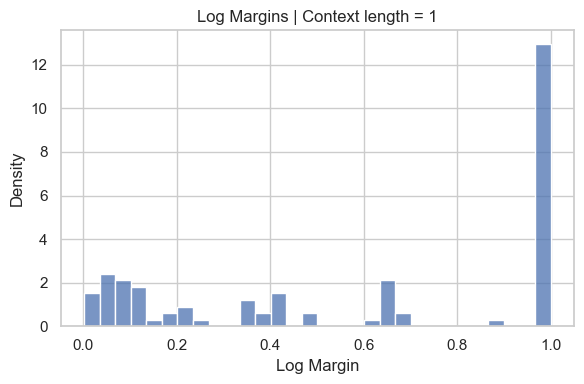

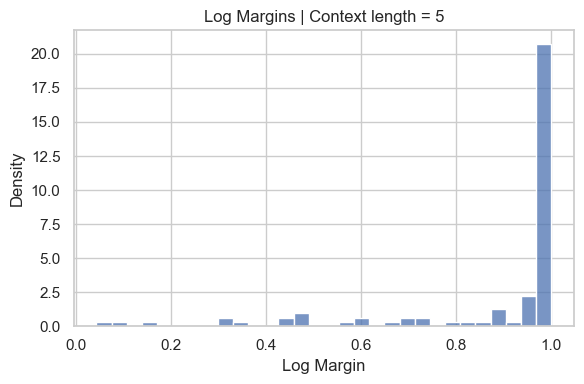

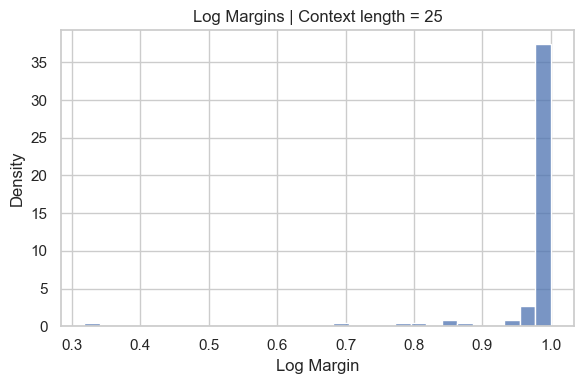

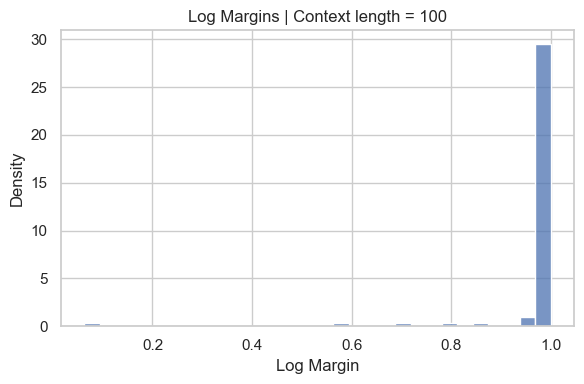

In [203]:
for ctx in eval_df["context_length"].unique():
    # print(ctx)
    plt.figure(figsize=(6, 4))

    sns.histplot(
        data=eval_df[eval_df["context_length"] == ctx],
        x="log_margins",
        bins=30,
        stat="density",
        common_norm=True,
        
    )

    plt.title(f"Log Margins | Context length = {ctx}")
    plt.xlabel("Log Margin")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


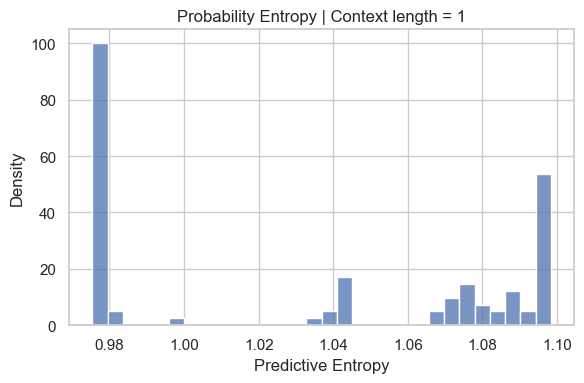

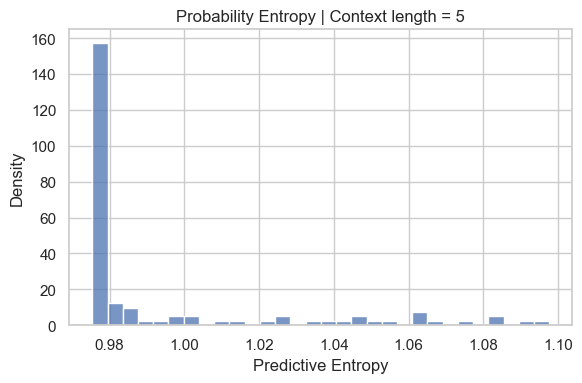

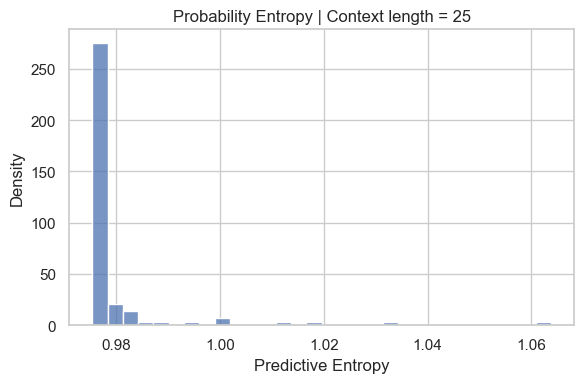

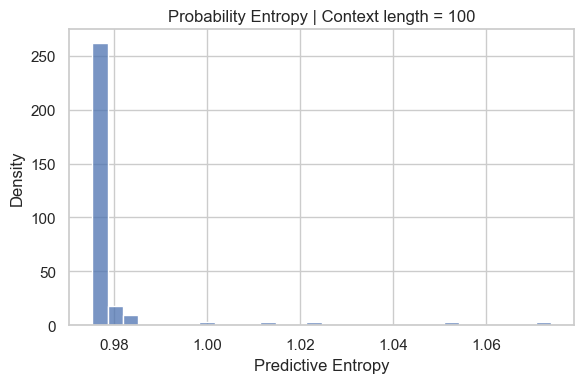

In [204]:
for ctx in eval_df["context_length"].unique():
    # print(ctx)
    plt.figure(figsize=(6, 4))

    sns.histplot(
        data=eval_df[eval_df["context_length"] == ctx],
        x="log_entropies",
        bins=30,
        stat="density",
        common_norm=True,
        
    )

    plt.title(f"Probability Entropy | Context length = {ctx}")
    plt.xlabel("Predictive Entropy")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


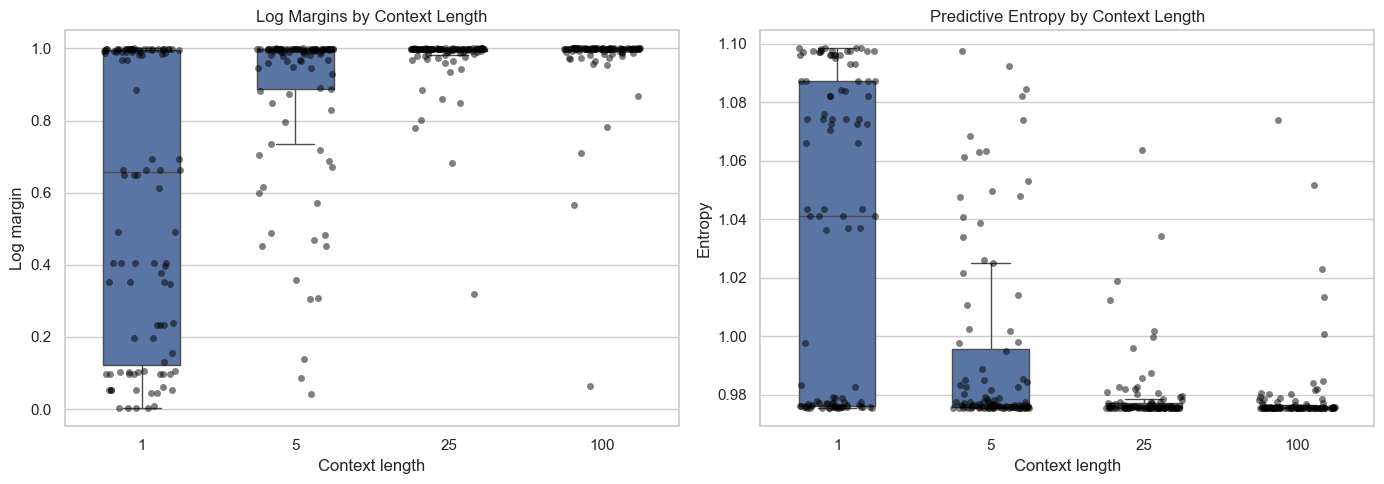

In [205]:
eval_df = eval_df.copy()
eval_df["context_length"] = eval_df["context_length"].astype(str)

# Shared style parameters
BOX_KWARGS = dict(
    showfliers=False,
    width=0.5   # default is ~0.8
)

POINT_KWARGS = dict(
    color="black",
    alpha=0.5,
    jitter=0.25,
    size=5
)

FIGSIZE = (14, 5)


fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, sharex=True)

# --- Log margins ---
sns.boxplot(
    data=eval_df,
    x="context_length",
    y="log_margins",
    ax=axes[0],
    **BOX_KWARGS
)

sns.stripplot(
    data=eval_df,
    x="context_length",
    y="log_margins",
    ax=axes[0],
    **POINT_KWARGS
)

axes[0].set_title("Log Margins by Context Length")
axes[0].set_xlabel("Context length")
axes[0].set_ylabel("Log margin")

# --- Entropy ---
sns.boxplot(
    data=eval_df,
    x="context_length",
    y="log_entropies",
    ax=axes[1],
    **BOX_KWARGS
)

sns.stripplot(
    data=eval_df,
    x="context_length",
    y="log_entropies",
    ax=axes[1],
    **POINT_KWARGS
)

axes[1].set_title("Predictive Entropy by Context Length")
axes[1].set_xlabel("Context length")
axes[1].set_ylabel("Entropy")

# axes[0].set_ylim(eval_df["log_margins"].quantile(0.01),
#                  eval_df["log_margins"].quantile(0.99))


plt.tight_layout()
plt.show()


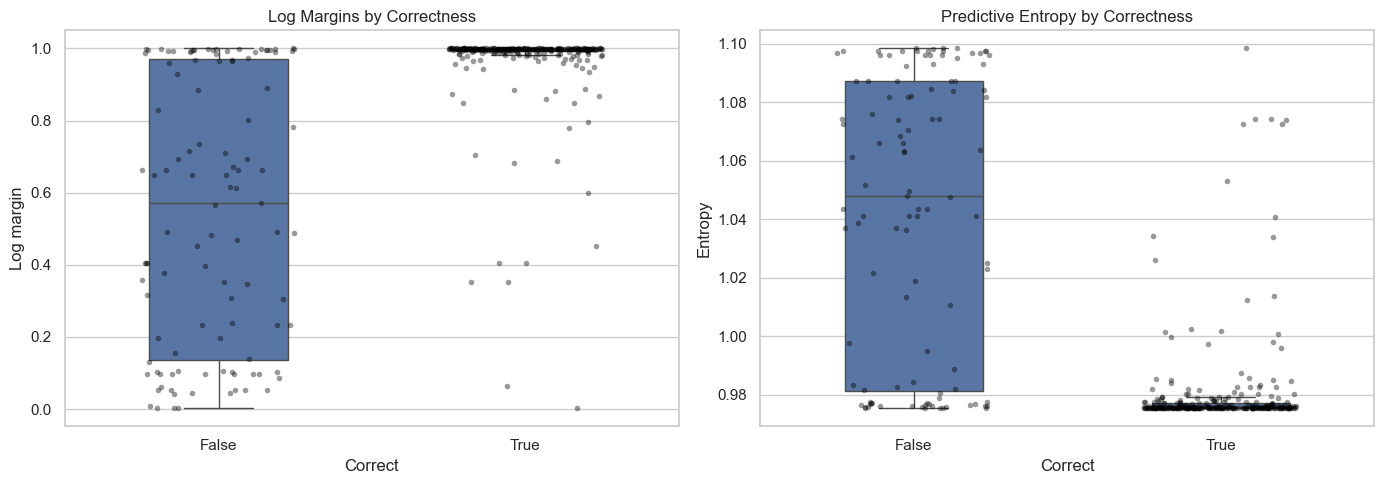

In [206]:

eval_df = eval_df.copy()
eval_df["correct"] = eval_df["correct"].astype(str)

BOX_KWARGS = dict(
    showfliers=False,
    width=0.45
)

POINT_KWARGS = dict(
    color="black",
    alpha=0.4,
    jitter=0.25,
    size=4
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# --- Log margins ---
sns.boxplot(
    data=eval_df,
    x="correct",
    y="log_margins",
    ax=axes[0],
    **BOX_KWARGS
)
sns.stripplot(
    data=eval_df,
    x="correct",
    y="log_margins",
    ax=axes[0],
    **POINT_KWARGS
)

axes[0].set_title("Log Margins by Correctness")
axes[0].set_xlabel("Correct")
axes[0].set_ylabel("Log margin")

# --- Entropy ---
sns.boxplot(
    data=eval_df,
    x="correct",
    y="log_entropies",
    ax=axes[1],
    **BOX_KWARGS
)
sns.stripplot(
    data=eval_df,
    x="correct",
    y="log_entropies",
    ax=axes[1],
    **POINT_KWARGS
)

axes[1].set_title("Predictive Entropy by Correctness")
axes[1].set_xlabel("Correct")
axes[1].set_ylabel("Entropy")

plt.tight_layout()
plt.show()


AttributeError: Line2D.set() got an unexpected keyword argument 'xlim'

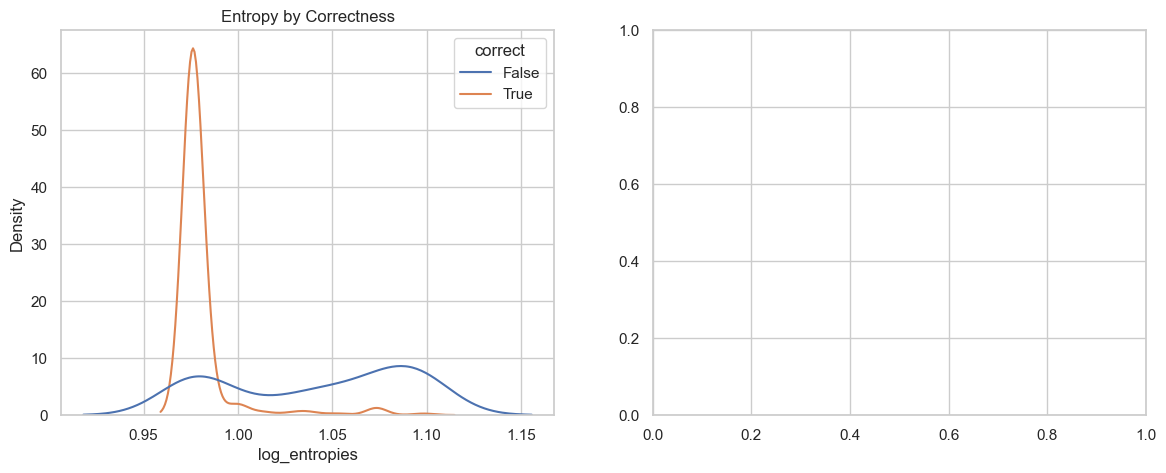

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=False)

sns.kdeplot(
    data=eval_df,
    x="log_entropies",
    hue="correct",
    ax=axes[0],
    bw_adjust=1.0,
    common_norm=False,
    # clip=(
    #     eval_df["log_entropies"].quantile(0.000001),
    #     eval_df["log_entropies"].quantile(0.999999),
    # )
)
axes[0].set_title("Entropy by Correctness")

sns.kdeplot(
    data=eval_df,
    x="log_margins",
    hue="correct",
    common_norm=False,
    bw_adjust=1.0,
    ax=axes[1],
    clip=(
        eval_df["log_margins"].quantile(0.00001),
        eval_df["log_margins"].quantile(0.99999),
    ),
    xlim=[0, 1]
)
axes[1].set_title("Log Margins by Correctness")

plt.tight_layout()
plt.show()


<Axes: xlabel='log_margins', ylabel='log_entropies'>

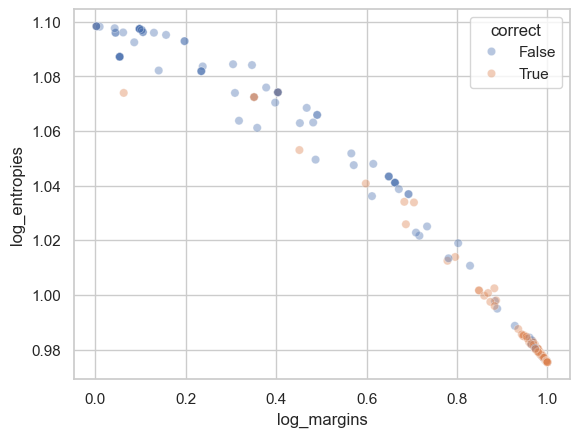

In [208]:
sns.scatterplot(
    data=eval_df,
    x="log_margins",
    y="log_entropies",
    hue="correct",
    alpha=0.4
)


In [ ]:
# Correct but high entropy
pd.set_option('display.max_colwidth', 120)

cols_of_interest = ['labels', 'preds', 'text', 'log_margins', 'log_entropies']

eval_df.query("correct").query("context_length == 100").sort_values(by='log_entropies', ascending=False)

,labels,text,preds,logprobs,log_margins,log_entropies,correct,context_length


In [ ]:
## Lets try masking

def prompt_text(template, txt):
    prompt = prompt_template.format(text=txt)
    result = get_logprobs(
        provider='ollama',
        model_id='llama3:8b',
        prompt=prompt,
        top_logprobs=3,
        temperature=0,
        invert_log=False
    )

    print("Prompt:", prompt)
    print("logprobs:")
    pprint(dict(result.logprobs))


def word_mask(prompt_template, txt, label, mask_label="<MASKED>", **logprob_kwargs):
    prompt = prompt_template.format(text=txt)
    base_logprobs = get_logprobs_cached(
        prompt=prompt,
        **logprob_kwargs
    ).logprobs
    # print(">>>", base_logprobs)

    base_margin = log_margin(base_logprobs)
    base_entropy = predictive_entropy(base_logprobs)

    words = txt.split(" ")
    df_rows = []

    for i, w in tqdm(enumerate(words), total=len(words)):
        modified = words.copy()
        modified[i] = mask_label
        
        modified_repr = words.copy()
        modified_repr[i] = "<MASKED>"
        masked_txt_repr = " ".join(modified_repr)
        masked_txt = " ".join(modified)

        prompt = prompt_template.format(text=masked_txt)

        logprobs = get_logprobs_cached(
            prompt=prompt,
            **logprob_kwargs
        ).logprobs

        margin = log_margin(logprobs)
        entropy = predictive_entropy(logprobs)

        max_token = max(logprobs, key=logprobs.get)

        row = {
            'masked_word': w,
            'masked_txt': masked_txt_repr,
            # 'masked_txt': masked_txt,
            'entropy_change': entropy - base_entropy,
            'margin_change': margin - base_margin,
            'top_choice': max_token,
            'top_choice_prob': logprobs[max_token],
            'masked_correct': max_token == label,
            'true_label': label,
        }

        # Per-label deltas (CRITICAL)
        for lbl in base_logprobs:
            lp = logprobs.get(lbl)
            if lp is not None:
                row[f'delta_logprob_{lbl}'] = lp - base_logprobs[lbl]
                
            # lp = logprobs.get(lbl, float('-inf'))
            # row[f'delta_logprob_{lbl}'] = lp - base_logprobs[lbl]

        df_rows.append(row)

    return pd.DataFrame(df_rows)

def token_masking_metrics(df, mask_label="", **logprob_kwargs):

    mask_dfs = []
    for _, row in df.iterrows():
        txt = row['text']
        label = row['labels']
        # print(txt)

        mask_df = word_mask(prompt_template, txt, label, mask_label=mask_label, **logprob_kwargs)
        mask_df['entropy_change_rank'] = mask_df['entropy_change'].rank(ascending=True)
        mask_df['margin_change_rank'] = mask_df['margin_change'].rank(ascending=False)
        mask_df['original_text'] = row['text']
        mask_df['unmasked_pred'] = row['preds']
        mask_df['unmasked_correct'] = row['correct']

        competitor = (
            mask_df['top_choice']
            .value_counts()
            .index
            .difference([label])[0]
        )

        mask_df['support_label'] = mask_df[f'delta_logprob_{label}']
        mask_df['suppress_competitor'] = -mask_df[f'delta_logprob_{competitor}']
        mask_df['net_effect'] = mask_df['support_label'] + mask_df['suppress_competitor']

        mask_dfs.append(mask_df)
    # return pd.concat(mask_dfs).sort_values('net_effect', ascending=False)
    return pd.concat(mask_dfs).sort_values('entropy_change_rank')

p = "token_mask_results.csv"
logprop_kwargs = {
	"provider": 'ollama',
	"model_id": 'llama3:8b',
	"top_logprobs": 5,
    "temperature": 0,
    "invert_log": False
}
token_mask_df = token_masking_metrics(eval_df.query("~correct & context_length == '100'").head(1000), **logprop_kwargs)
token_mask_df['prompt_id'] = token_mask_df.groupby('original_text').ngroup()

100%|██████████| 15/15 [00:00<00:00, 4644.17it/s]


In [ ]:
token_mask_df.sort_values(by='entropy_change', ascending=False)[['prompt_id', 'original_text', 'unmasked_pred', 'masked_word', 'entropy_change', 'margin_change', 'support_label', 'top_choice', 'true_label']]


,prompt_id,original_text,unmasked_pred,masked_word,entropy_change,margin_change,support_label,top_choice,true_label
13,3,Tại giza các kim tự tháp có một buổi biểu diễn hàng đêm bằng tiếng anh .,en,bằng,0.786043,-4.077074,3.800038,vi,vi
3,5,"os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão",et,defesa,0.601630,-1.487698,1.731594,pt,pt
10,1,"Kwa wingi wa beachfront , mgahawa wa kifaransa wa juu ( la mer ) , na nyumba ya maeneo bila lounge y",fr,(,0.549880,-7.389917,7.508484,fr,sw
0,3,Tại giza các kim tự tháp có một buổi biểu diễn hàng đêm bằng tiếng anh .,en,Tại,0.544780,-1.979552,4.210926,vi,vi
4,3,Tại giza các kim tự tháp có một buổi biểu diễn hàng đêm bằng tiếng anh .,en,tự,0.499417,-2.991718,2.767026,en,vi
...,...,...,...,...,...,...,...,...,...
4,2,Mapinda not extradited kwa spain,zu,spain,-0.467352,2.434129,NaN,zu,sw
3,2,Mapinda not extradited kwa spain,zu,kwa,-0.650780,2.215065,NaN,es,sw
0,2,Mapinda not extradited kwa spain,zu,Mapinda,-0.696877,3.274668,-0.111293,es,sw
1,2,Mapinda not extradited kwa spain,zu,not,-0.728660,4.143640,NaN,es,sw


In [ ]:
eval_df.query("~correct & context_length == '100'").head(100)

,labels,text,preds,logprobs,log_margins,log_entropies,correct,context_length
0,pt,"os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão",et,"{'et': 0.8836959916064103, 'pt': 0.10233953308022108, 'es': 0.005111685714729211}",0.781356,1.013407,False,100
22,sw,Mapinda not extradited kwa spain,zu,"{'es': 0.7246186310568435, 'zu': 0.15839741034988558, 'sv': 0.0581389361815905}",0.566221,1.051827,False,100
33,pt,Ucrânia: Nove pessoas morrem em confrontos de Kyiv,uk,"{'uk': 0.9956358132500743, 'pt': 0.0041429183340138155, ' uk': 5.46489302904582e-05}",0.991493,0.976901,False,100
63,vi,Tại giza các kim tự tháp có một buổi biểu diễn hàng đêm bằng tiếng anh .,en,"{'en': 0.9852413823513202, 'vi': 0.012280518023969643, 'vn': 0.0012028706201487602}",0.972961,0.980527,False,100
73,sw,"Kwa wingi wa beachfront , mgahawa wa kifaransa wa juu ( la mer ) , na nyumba ya maeneo bila lounge y",fr,"{'fr': 0.9996372911756215, 'fra': 0.00016988101249439762, 'sw': 0.00011771399402816069}",0.999467,0.975451,False,100
74,sw,Kwa paka anyway unajua vizuri usikie it ' s been a pleasure talking to you,en,"{'en': 0.853482175452887, 'sw': 0.14422992795315392, 'sv': 0.0007641744781582239}",0.709252,1.022818,False,100


In [ ]:
from IPython.display import HTML, display
import html

def colorize_sentence(
    text,
    token_effects,
    max_abs_effect=None
):
    """
    token_effects: dict {token: scalar_effect}
                   effect > 0  => helpful (green)
                   effect < 0  => harmful (red)
                   effect = 0  => neutral (gray)
    """

    tokens = text.split(" ")

    if max_abs_effect is None:
        max_abs_effect = max(abs(v) if not np.isnan(v) else -99999 for v in token_effects.values())

    def interpolate_color(effect, max_abs):
        """
        Interpolate between red (-max) -> gray (0) -> green (+max)
        """
        if max_abs == 0 or np.isnan(effect):
            # return "#808080"  # gray
        	return "#ffffff"  # white
        
        # Normalize effect to [-1, 1]
        normalized = effect / max_abs
        
        if normalized > 0:
            # Interpolate from gray (#808080) to green (#2ecc71)
            r = int(128 + (46 - 128) * normalized)
            g = int(128 + (204 - 128) * normalized)
            b = int(128 + (113 - 128) * normalized)
        else:
            # Interpolate from gray (#808080) to red (#e74c3c)
            normalized = abs(normalized)
            r = int(128 + (231 - 128) * normalized)
            g = int(128 + (76 - 128) * normalized)
            b = int(128 + (60 - 128) * normalized)
        
        return f"#{r:02x}{g:02x}{b:02x}"

    spans = []
    for tok in tokens:
        effect = token_effects.get(tok, 0.0)
        color = interpolate_color(effect, max_abs_effect)

        spans.append(
            f'<span style="background-color:{color};'
            f'padding:2px 4px;border-radius:3px;">'
            f'{html.escape(tok)}</span>'
        )

    html_out = "<div style='font-size:20px;line-height:2'>" + " ".join(spans) + "</div>"
    display(HTML(html_out))
    

def safe_transform(x):
    if np.isnan(x) or x == 0:
        return 0
    else:
        # return x
        return np.log(x)





In [ ]:

# df_ = token_mask_df[token_mask_df['original_text'].str.startswith("Devasa 12")]
for i in token_mask_df['prompt_id'].unique():
    df_ = token_mask_df[token_mask_df['prompt_id'] == i]
    token_effects = {
        # row["masked_word"]: -row["delta_logprob_fr"]
        # row["masked_word"]: -row["delta_logprob_tr"]
        # row["masked_word"]: safe_transform(-row["delta_logprob_tr"])
        # row["masked_word"]: safe_transform(row["delta_logprob_fr"])
        # row['masked_word']: safe_transform(-row['entropy_change'])
        # row["masked_word"]: -safe_transform(row['delta_logprob_vi'])
        row["masked_word"]: safe_transform(row['support_label'])
        # row['ma']
        for _, row in df_
        .iterrows()
    }
    original_text = df_['original_text'].iloc[0]
    pd.Series(token_effects).sort_values()

    colorize_sentence(original_text, token_effects)

/var/folders/b3/92n6z87s0t93y9pmdlz3_66dcd4_mv/T/ipykernel_61263/304306792.py:66: RuntimeWarning: invalid value encountered in log
  return np.log(x)


# Experiment 2: Multi-class Classification

[Explain]

First mix and match different samples.

In [ ]:
import random
import string


def add_text_noise(
    text: str,
    noise_prob: float = 0.0,
    delete_prob: float = 0.33,
    swap_prob: float = 0.33,
    # replace_prob: float = 0.34,
    # alphabet: str = string.ascii_lowercase + string.ascii_uppercase
) -> str:
    """
    Add character-level noise to a string.
    Noise operations:
      - delete a character
      - swap with next character
      - replace with random character
    """
    if noise_prob <= 0.0:
        return text

    chars = list(text)
    i = 0

    while i < len(chars):
        if random.random() < noise_prob:
            r = random.random()

            # delete
            if r < delete_prob:
                chars.pop(i)
                continue

            # swap
            elif r < delete_prob + swap_prob and i < len(chars) - 1:
                chars[i], chars[i + 1] = chars[i + 1], chars[i]
                i += 2
                continue

            # replace
            # else:
            #     chars[i] = random.choice(alphabet)

        i += 1

    return "".join(chars)


import pandas as pd
import random


def generate_mixed_samples(
    df: pd.DataFrame,
    min_texts: int = 1,
    max_texts: int = 5,
    noise_prob: float = 0.0,
    shuffle: bool = True,
    label_sep: str = ","
) -> pd.DataFrame:
    """
    Generate mixed text samples without replacement and
    without repeating the same language (label) in one sample.
    """

    assert {"text", "labels"}.issubset(df.columns)

    indices = list(df.index)
    if shuffle:
        random.shuffle(indices)

    samples = []
    used = set()
    i = 0

    while i < len(indices):
        if indices[i] in used:
            i += 1
            continue

        k = random.randint(min_texts, max_texts)
        chosen = []
        used_labels = set()

        for idx in indices[i:]:
            if idx in used:
                continue

            label = df.at[idx, "labels"]

            # prevent sampling same language twice
            if label in used_labels:
                continue

            chosen.append(idx)
            used_labels.add(label)

            if len(chosen) == k:
                break

        if len(chosen) == 0:
            i += 1
            continue

        # mark rows as used globally
        for idx in chosen:
            used.add(idx)

        texts = df.loc[chosen, "text"].tolist()
        labels = sorted(df.loc[chosen, "labels"].tolist())

        combined_text = "\n\n".join(texts)
        combined_text = add_text_noise(combined_text, noise_prob=noise_prob)

        # order-invariant multiclass label
        # combined_label = label_sep.join(sorted(map(str, labels)))
        # combined_label = label_sep.join(sorted(map(str, labels)))
        # combined_label = ;abes

        samples.append((combined_text, labels))

        i += len(chosen)

    return pd.DataFrame(samples, columns=["text", "labels"])

random.seed(42)
mixed_df = generate_mixed_samples(df.head(1000), noise_prob=0.1)
# for x in mixed_df['labels'].str.split()

In [ ]:
# Naive approach is to ask for multiple labels

prompt_template_multi = """
Given the text below, determine the most appropriate ISO 639-1 language codes for the text based on the language the text was written in. Each paragraph is a different language.

Rules:
- Choose one or more codes
- Output the codes in a comma separate output (i.e. "en,fr")
- Do not repeat codes
- Do not explain your answer.
- Do not output anything except the ISO codes.

Text:
{text}

Language codes:
"""

prompt = prompt_template_multi.format(text="Hi, how are you doing? Hallo, hoe gaat het met jou? Wie geht's dir?")

response = get_logprobs(provider='ollama', model_id='llama3:8b', prompt=prompt, temperature=0, top_k=1)

response.response_text, response.logprobs

('en,en,de',
 OrderedDict([('en', 0.9999746844972202),
              ('de', 3.689209105873317e-06),
              ('es', 3.661903073455314e-06),
              ('nl', 2.8074000209321137e-06),
              ('En', 2.448508369618168e-06),
              ('EN', 2.0612530888555818e-06),
              ('fr', 2.021134254119395e-06),
              ('English', 1.883239639411168e-06),
              ('.en', 1.165629160111066e-06),
              ('/en', 8.560012541591888e-07)]))

In [ ]:
def evaluate_naive(df, **logprob_kwargs):
    preds = []
    corrects = []
    df = df.copy()

    for _, row in tqdm(df.iterrows(), total=len(df)):
        txt = row['text']

        prompt = prompt_template_multi.format(text=txt)

        res = get_logprobs_cached(prompt=prompt, **logprob_kwargs)
        
        pred = res.response_text
        pred = sorted([x.strip() for x in pred.split(',')])
        corrects.append(pred == row['labels'])
        preds.append(pred)

    df['preds'] = preds
    df['correct'] = corrects

    return df

evaluate_naive(mixed_df.head(), model_id='llama3:8b', provider='ollama')

100%|██████████| 5/5 [00:00<00:00, 2382.04it/s]


,text,labels,preds,correct
0,1 ء میں ہونے والے س کے بارے یں گفتگو کرنے کے لےئ ، 1 ء میں سرکاری طور پر عوامی وسیلوں اور خدمات کا استعمال کرنے کے ل...,"[en, pt, ur, zh]","[en, pt, uk, ur]",False
1,Jornalistassírios mortos na capital\n\nn aimlae marrone peloso sta detr oad alcune piante.,"[it, pt]","[it, pt]",True
2,"Aasema : labda !\n\nHnơ là têm một lớp môi trường theo quy định của môi trườngở trên cùng củan hng người hiệ có , cú...","[sw, th, vi]","[es, th, vi]",False
3,"Muy útil, cumple exactaemnte cn la descrición del ariculo\n\nนักวิทยาศาตสร์ don ' มี คำตอบ สำหรบ คน นี\n้\n...","[el, es, th, tr]","[el, es, th]",False
4,"Après un premier essai infructueux dans els permiers jour,s le produit marhce très bien. C est souvent ce câbleq u p...","[el, fr, hi]","[el, en, fr, hin]",False


In [ ]:
evaluate_naive(mixed_df.head(), model_id='gemini-2.5-flash-lite', provider='gemini')

100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


,text,labels,preds,correct
0,1 ء میں ہونے والے س کے بارے یں گفتگو کرنے کے لےئ ، 1 ء میں سرکاری طور پر عوامی وسیلوں اور خدمات کا استعمال کرنے کے ل...,"[en, pt, ur, zh]","[en, pt, ur, zh]",True
1,Jornalistassírios mortos na capital\n\nn aimlae marrone peloso sta detr oad alcune piante.,"[it, pt]","[it, pt]",True
2,"Aasema : labda !\n\nHnơ là têm một lớp môi trường theo quy định của môi trườngở trên cùng củan hng người hiệ có , cú...","[sw, th, vi]","[sw, th, vi]",True
3,"Muy útil, cumple exactaemnte cn la descrición del ariculo\n\nนักวิทยาศาตสร์ don ' มี คำตอบ สำหรบ คน นี\n้\n...","[el, es, th, tr]","[el, es, th, tr]",True
4,"Après un premier essai infructueux dans els permiers jour,s le produit marhce très bien. C est souvent ce câbleq u p...","[el, fr, hi]","[el, fr, hi]",True


In [ ]:
mixed_df.head().iloc[0]['text']

'1 ء میں ہونے والے س کے بارے یں گفتگو کرنے کے لےئ ، 1 ء میں سرکاری طور پر عوامی وسیلوں اور خدمات کا استعمال کرنے کے لئے اقتصادی طور پرت عاون یافتہ\n\nterribly mae. chaep material. broken zipper\n\n挺有比格的，就是有点小磨损 来的时候这就样了\n\nUcrânia: Nove pssoas morrem em confronto sde Kyiv'

In [ ]:
# multiclass score metrics?



In [ ]:
prompt = prompt_template.format(text="Hello, how are you? Hallo hoe gaat het? Ola, que tale?")
print("Prompt:", prompt)
# get_logprobs_cached(prompt=prompt, model_id='llama3:8b', provider='ollama', invert_log=True).logprobs
get_logprobs_cached(prompt=prompt, model_id='gemini-2.5-flash-lite', provider='gemini', invert_log=True).logprobs

Prompt: 
Given the text below, determine the single most appropriate ISO 639-1 language code based on what language the text is written in. 

Rules:
- Do not explain your answer.
- Do not output any punctuation marks.
- Do not output anything except the ISO 639-1 compliant code.

Text:
Hello, how are you? Hallo hoe gaat het? Ola, que tale?

Language code:



OrderedDict([('en', 0.8390305422659313),
             ('und', 0.10300462385129096),
             ('multi', 0.040041914940176296),
             ('mul', 0.012240406397977553),
             ('xx', 0.0030078335806705808),
             ('un', 0.0007497857941706892),
             ('fr', 0.00028919799517990825),
             ('z', 0.00024511158552095085),
             ('mult', 0.00023141347787006036),
             ('zu', 9.872029594397011e-05)])

In [ ]:
def evaluate_multi_logprobs(df, threshold=0.5, **logprob_kwargs):
    preds = []
    corrects = []
    df = df.copy()

    for _, row in tqdm(df.iterrows(), total=len(df)):
        txt = row['text']

        prompt = prompt_template.format(text=txt)

        res = get_logprobs_cached(prompt=prompt, **logprob_kwargs)
        
        pred = res.response_text
        pred = sorted([x.strip() for x in pred.split(',')])
        corrects.append(pred == row['labels'])
        preds.append(pred)

    df['preds'] = preds
    df['correct'] = corrects

evaluate_multi_logprobs(mixed_df.head(), model_id='llama3:8b', provider='ollama', invert_log=True)

  0%|          | 0/5 [01:19<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('synthetic_dataset.csv')
print(df)

                                                                            text  \
0  Regular training teaches teamwork and discipline that boost academic success.   

                    topics  
0  ['Sports', 'Education']  


In [ ]:
y_true = pd.get_dummies(df['topics'].explode()).groupby(level=0).sum()
y_true = y_true.reindex(columns=['Sports', 'Education'], fill_value=0)
y_true


,Sports,Education
0,0,0


In [ ]:



def process_dataset_ollama(df, model, verbose=False):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing with {model}'):
        probs = get_ollama_topic_probs(row['text'], model=model, verbose=verbose)
        results.append(probs)
    return pd.DataFrame(results)

def analyze_thresholds(y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)
    results = []
    for t in thresholds:
        y_pred = (y_prob > t).astype(int)
        results.append({
            'threshold': t,
            'f1': f1_score(y_true, y_pred, average='samples', zero_division=0),
            'precision': precision_score(y_true, y_pred, average='samples', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='samples', zero_division=0)
        })
    return pd.DataFrame(results)

def plot_analysis(df_analysis, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df_analysis['threshold'], df_analysis['f1'], label='F1 Score')
    plt.plot(df_analysis['threshold'], df_analysis['precision'], label='Precision')
    plt.plot(df_analysis['threshold'], df_analysis['recall'], label='Recall')
    best_threshold = df_analysis.loc[df_analysis['f1'].idxmax()]
    plt.axvline(x=best_threshold['threshold'], color='r', linestyle='--', label=f'Best Threshold (F1={best_threshold["f1"]:.2f})')
    plt.title(f'Performance vs. Threshold for {model_name}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'Best threshold for {model_name}: {best_threshold["threshold"]:.2f} with F1={best_threshold["f1"]:.2f}')


process_dataset_ollama